# Machine Learning

In part 1, we identified that boosting appear to have the best performance on the predictions. In this part, we will work on feature reductions on the categorical variables (116 of them) through the use of One Hot Encoding, LassoCV, and RFE.

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    ExtraTreesRegressor,
    RandomForestRegressor,
)
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LassoCV, LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from xgboost.sklearn import XGBRegressor

In [2]:
df = pd.read_csv('./data/train.csv', index_col=0)
train_df = df.drop(['cont9', 'cont10', 'cont12', 'cont13'], axis=1)

In [3]:
# obtain target and feature columns
target = train_df['loss']
feature = train_df.drop(['loss'], axis=1)

In [4]:
# separate out categorical and continuous variables. We will perform feature reduction on the categorical table, and merge the two tables back later.
cat_df = feature.select_dtypes(include=['O'])
con_df = feature.select_dtypes(include=['float'])

In [5]:
cat_encoded = pd.get_dummies(cat_df, drop_first=True, prefix=cat_df.columns)

In [6]:
encoded_df = pd.merge(cat_encoded, con_df, left_index=True,
                      right_index=True, how='inner')

encoded_df.shape

(188318, 1033)

Total of 1033 variables are formed. From the exploratory analysis, we also find out the target variables would need power transformation.

In [7]:
p_trans = PowerTransformer()

train_df['loss_transform'] = p_trans.fit_transform(train_df[['loss']])

target_t = train_df['loss_transform']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(encoded_df, target_t,
                                                    test_size=.3, random_state=42)

In [9]:
lcv = LassoCV()
lcv.fit(X_train, y_train)
print('Best R square score is {:.2f}'.format(lcv.score(X_test, y_test)))
print('Best alpha is {:.2f}'.format(lcv.alpha_))

Best R square score is 0.51
Best alpha is 0.00


In [10]:
lcv_mask = lcv.coef_ != 0
sum(lcv_mask)

293

Out of 1033 variables, only 293 of them have non-zero values. Based on this, we will run RFE, using Lightgbm and Xgboost regressor, to select the optimal 293 features.

We will using voting system to choose features that are selected by all three estimators.

In [11]:
rfe_lgb = RFE(estimator=LGBMRegressor(),
              n_features_to_select=293, step=50, verbose=0)
rfe_lgb.fit(X_train, y_train)

RFE(estimator=LGBMRegressor(), n_features_to_select=293, step=50)

In [12]:
rfe_xgb = RFE(estimator=XGBRegressor(objective='reg:squarederror'),
              n_features_to_select=293, step=50, verbose=0)
rfe_xgb.fit(X_train, y_train)

RFE(estimator=XGBRegressor(objective='reg:squarederror'),
    n_features_to_select=293, step=50)

In [13]:
lgb_mask = rfe_lgb.support_
xgb_mask = rfe_xgb.support_

In [14]:
votes = np.sum([lcv_mask, lgb_mask, xgb_mask], axis=0)
mask = votes == 3

In [15]:
reduced_df = encoded_df.loc[:, mask]
reduced_df.shape

(188318, 123)

Out of the 293 feature being evaluated, 123 of them got picked by all three estimators. We will try to further optimize the dataset by using RFECV to see if we can narrow down to more precise features set. We will use LGBMRegressor per part 1 results.

In [16]:
rfecv = RFECV(estimator=LGBMRegressor(), step=1, cv=2,
              scoring='neg_mean_absolute_error', n_jobs=-1)

In [17]:
selector = rfecv.fit(reduced_df,  target_t)

In [18]:
mask_sel = selector.support_

rfecv_df = reduced_df.loc[:, mask_sel]

In [19]:
rfecv_df.shape

(188318, 112)

Another 11 features got removed, we are left with a dataset of 112 features. Save this set of features into a separate file for later use in transforming test dataset.

In [20]:
final_train = pd.merge(rfecv_df, target, left_index=True, right_index=True)

In [21]:
final_train.to_csv('./data/final_train.csv', index=True)

##### Prepare train and test sets for model comparison

In [22]:
train_X, test_X, train_y, test_y = train_test_split(
    rfecv_df, target, test_size=.3, random_state=42)

In [23]:
def mae_fun(name, model):
    """ MAE calculated with 5 fold validations

    Args:
        name : the name of the model being applied
        model : the model that will be used to train and generate predictions

    Returns:
        MAE scores    
    """
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, rfecv_df, target, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    mae = np.mean(np.absolute(scores))
    print('MAE of using {} is {:.2f}'.format(name, mae))

We will rerun all the models with the updated dataframe with categorical variables from part 1 to observe potential improvement on accuracy.

### Dummy and Linear Regression Models

In [25]:
regressors = {'dummy': DummyRegressor(), 'linear': LinearRegression(), 'ridge': Ridge(),
              'SGD': SGDRegressor()}

base MAE is 1810.0915085927318
MAE of using dummy is 1809.28
base MAE is 1285.2403126813938
MAE of using linear is 1278.33
base MAE is 1285.2161863170472
MAE of using ridge is 1278.31
base MAE is 1286.7710998008606
MAE of using SGD is 1278.18


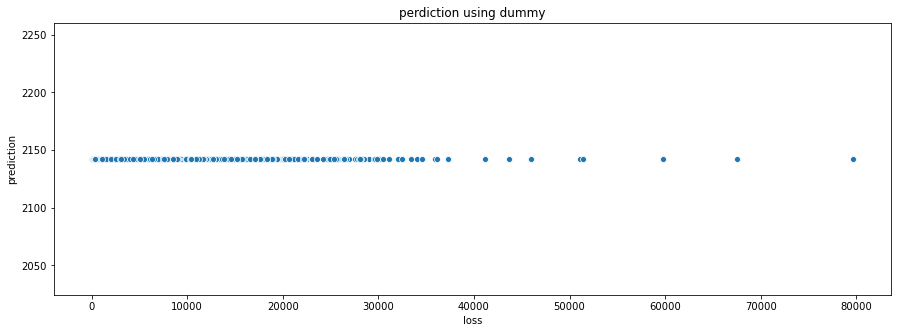

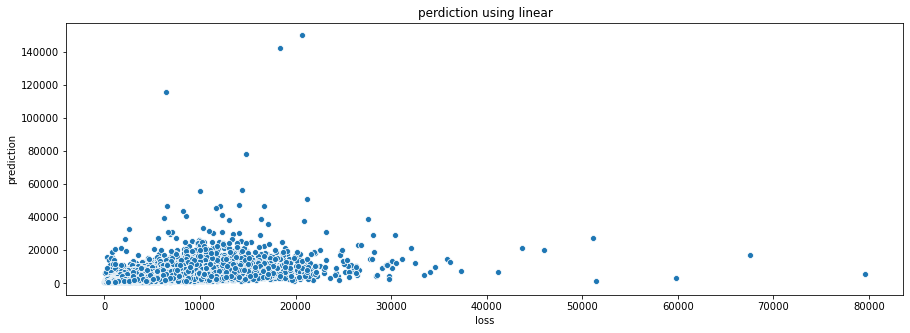

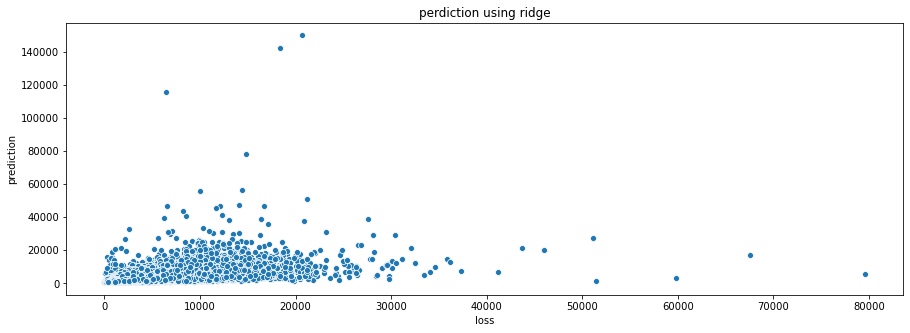

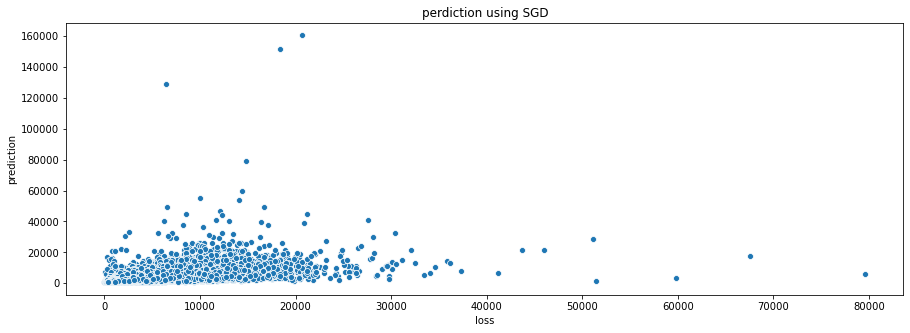

In [26]:
for name, reg in regressors.items():
    mod = TransformedTargetRegressor(
        regressor=reg, transformer=PowerTransformer())
    mod_fit = mod.fit(train_X, train_y)
    pred = mod_fit.predict(test_X)
    print('base MAE is {}'.format(mean_absolute_error(pred, test_y)))
    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=test_y, y=pred)
    plt.ylabel('prediction')
    plt.title(f'perdiction using {name}')
    mae_fun(name, mod)

MAE reduced from 1800 range to 1300 range, huge improvements given models are simple linear regression. 

### Tree Base Ensemble Model



In [27]:
tree_base = {'extra_tree': ExtraTreesRegressor(
), 'random_forest': RandomForestRegressor()}

base MAE is 1252.6036057103156
MAE of using extra_tree is 1249.72
base MAE is 1219.658562729974
MAE of using random_forest is 1215.31


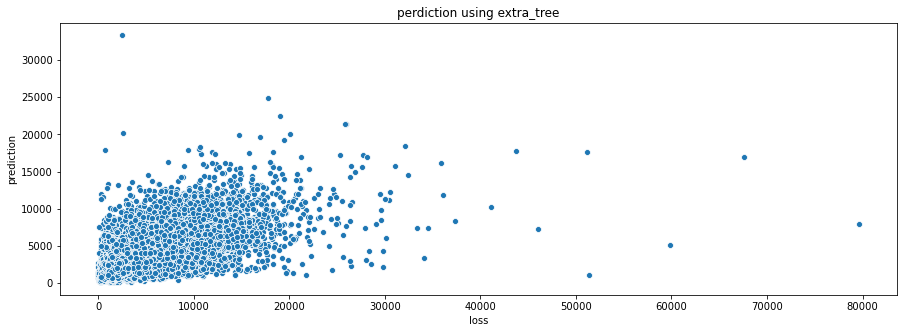

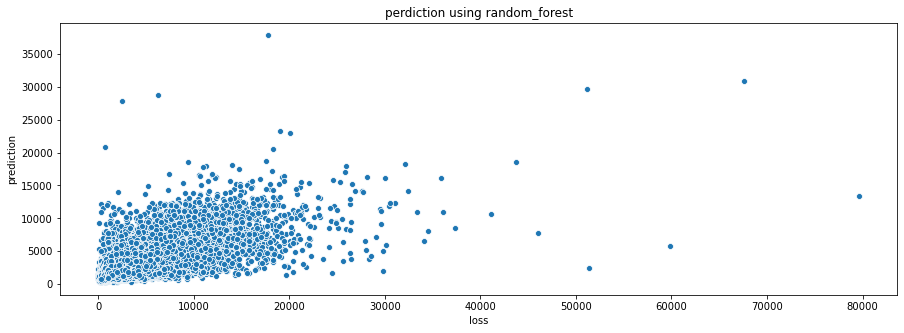

In [28]:
for name, reg in tree_base.items():
    mod = TransformedTargetRegressor(
        regressor=reg, transformer=PowerTransformer())
    mod_fit = mod.fit(train_X, train_y)
    pred = mod_fit.predict(test_X)
    print('base MAE is {}'.format(mean_absolute_error(pred, test_y)))
    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=test_y, y=pred)
    plt.ylabel('prediction')
    plt.title(f'perdiction using {name}')
    mae_fun(name, mod)

Tree base model improved on linear regression models by dropping MAE by ~50. While it is an improvement we want to keep, the model training time is substantially longer and may not be a good model to deploy in the scaling stage.

### Boosting

In [29]:
booster = {'ada': AdaBoostRegressor(), 'lightgbm': LGBMRegressor(),
           'xgboost': XGBRegressor(objective='reg:squarederror')}

base MAE is 1705.3497021209514
MAE of using ada is 1653.00
base MAE is 1164.5596548561102
MAE of using lightgbm is 1161.57
base MAE is 1219.9499634447209
MAE of using xgboost is 1217.36


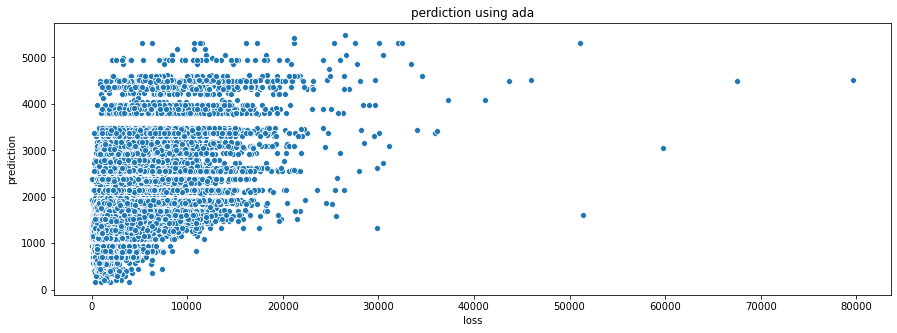

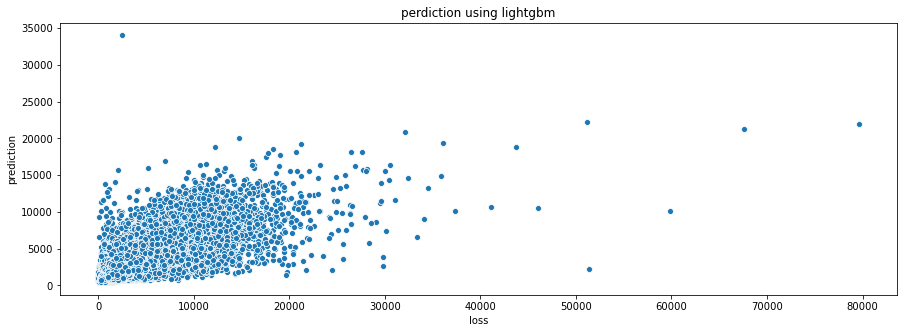

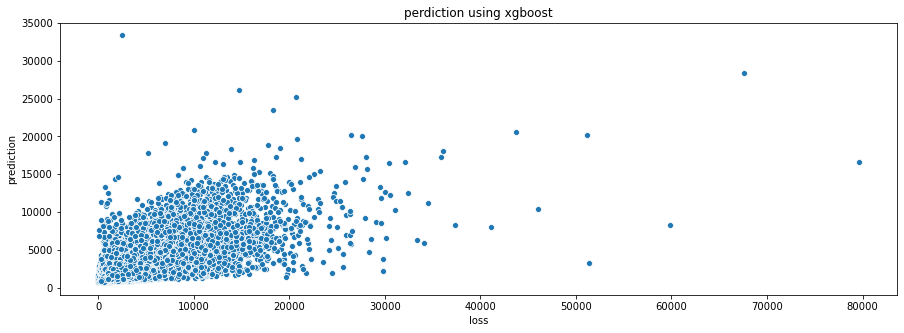

In [30]:
for name, reg in booster.items():
    mod = TransformedTargetRegressor(
        regressor=reg, transformer=PowerTransformer())
    mod_fit = mod.fit(train_X, train_y)
    pred = mod_fit.predict(test_X)
    print('base MAE is {}'.format(mean_absolute_error(pred, test_y)))
    plt.figure(figsize=(15, 5))
    sns.scatterplot(x=test_y, y=pred)
    plt.ylabel('prediction')
    plt.title(f'perdiction using {name}')
    mae_fun(name, mod)

Xgboost has similar performance as random forecast, but the processing time is much shorter. Lightgbm has even better performance than Xgboost when in terms of MAE and processing time, which makes it the winning model so far. We will make predictions based on Lightgbm and Xgboost and fine tune parameters to optimizes MAE.

### Category Boosting

Given the large amount of categorical variables in the dataset, we wonder if Catboost could be a good solution for the problem due to its effective handling of categorical variables. Catboost does not require one-hot encoding and can fit the categorical columns directly.

In [40]:
le = LabelEncoder()
cat_label = feature.apply(le.fit_transform)

In [39]:
cat_label.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont11,cont14
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,1,0,0,0,0,1,0,...,483,21,26,70,4,1670,1202,14,147,14051
2,0,1,0,0,0,0,0,0,1,1,...,206,29,47,49,86,872,2147,66,90,4545
5,0,1,0,0,1,0,0,0,1,1,...,152,23,42,9,15,419,1014,8,102,15976
10,1,1,0,1,0,0,0,0,1,0,...,199,26,44,25,18,877,1746,17,87,11694
11,0,1,0,1,0,0,0,0,1,1,...,159,19,44,35,52,110,417,2,47,8913


In [41]:
catX_train, catX_test, caty_train, caty_test = train_test_split(
    cat_label, target, test_size=.3, random_state=42)

In [42]:
cat = TransformedTargetRegressor(
    regressor=CatBoostRegressor(), transformer=PowerTransformer())

In [43]:
cat_fit = cat.fit(catX_train, caty_train,
                  cat_features=cat_df.columns, verbose=0)

base MAE is 1158.2961709804845


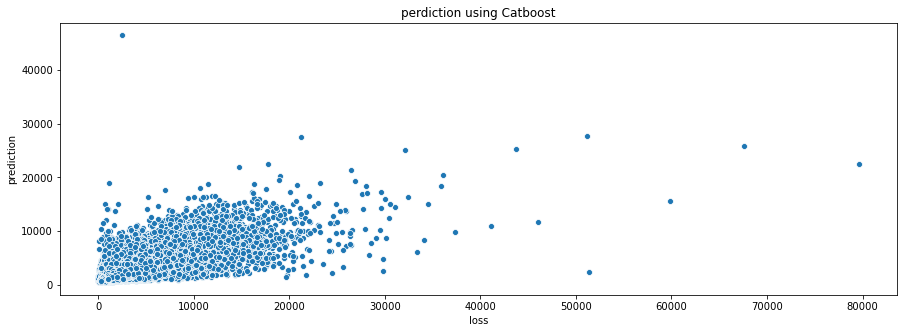

In [46]:
cat_pred = cat_fit.predict(catX_test)
plt.figure(figsize=(15, 5))
sns.scatterplot(x=caty_test, y=cat_pred)
plt.ylabel('prediction')
plt.title(f'perdiction using Catboost')
print('base MAE is {}'.format(mean_absolute_error(cat_pred, caty_test)))

In [49]:
cv_cat = KFold(n_splits=5, shuffle=True, random_state=42)
scores_cat = cross_val_score(
        cat, cat_label, target, scoring='neg_mean_absolute_error', cv=cv_cat, n_jobs=-1)
mae = np.mean(np.absolute(scores_cat))
print('MAE of using {} is {:.2f}'.format('catboost', mae))

MAE of using catboost is 1157.77


The performance for catboost without any tunning is better than all other estimators.

#### Model Performance (Train data with CV =5, no tuning)

| Model | Performance | Time |
| ---- | ---- | ---- |
|Dummy | 1809 | 1s |
|Linear Reg | 1278 | 3s |
|Ridge | 1278 | 3s|
|SGD | 1278 | 3s|
|Extra Tree | 1249 | 10 minutes|
|Random Forecast | 1219 | 23 minutes|
|Ada | 1653 | 1 minute |
|Lightgbm | 1161 | 1 minute |
|Xgboost | 1217 | 3 minutes |
|Catboost | 1157 | 19 minutes |



**Summary**:

Given similar model performance, we will keep SGD regression model in the final model tunning exercise. Tree base models overall has better performance than linear models but is very slow on model fitting, and will not be considered.

Boosting models have the best performance, with Lightbgm having decent MAE and processing time. Catboost has the best performance but the processing time is quite long. We won't keep Ada as the MAE performance is worse than other models, but keep Lightgbm, xgboost, and Catboost in the model tuning section.